<a href="https://colab.research.google.com/github/T-Yamaguch/WGAN/blob/master/WGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Concatenate, Conv2D, \
MaxPooling2D, Activation, ReLU, LeakyReLU, UpSampling2D, BatchNormalization, \
Dropout, Dense, Flatten, Add, LayerNormalization, GaussianNoise, Reshape, Lambda
from keras.regularizers import l2

class conv_block(Model):
  def __init__(self, filter_num, kernel_size, kernel_regularizer= l2(0.001)):
    super(conv_block, self).__init__()
    self.conv = Conv2D(filter_num, kernel_size, padding = 'same', kernel_regularizer= kernel_regularizer)
    self.norm = BatchNormalization(trainable=True)
    self.act = ReLU()
    self.up = UpSampling2D((2,2))
    self.noise = GaussianNoise(0.2)

  def call(self, x):
    x = self.conv(x)
    x = self.norm(x)
    x = self.act(x)
    x = self.up(x)
    x = self.noise(x)
    return x

class res_block(Model):
  def __init__(self, filter_num, kernel_size, kernel_regularizer= l2(0.001)):
    super(res_block, self).__init__()
    self.conv1 = Conv2D(filter_num, kernel_size, padding = 'same', kernel_regularizer= kernel_regularizer)
    self.conv2 = Conv2D(filter_num, kernel_size, padding = 'same', kernel_regularizer= kernel_regularizer)
    self.norm1 = BatchNormalization(trainable=True)
    self.norm2 = BatchNormalization(trainable=True)
    self.act1 = ReLU()
    self.act2 = ReLU()
    self.add = Add()

  def call(self, x):
    y = self.conv1(x)
    y = self.norm1(y)
    y = self.act1(y)
    y = self.conv2(y)
    y = self.norm2(y)
    y = self.act2(y)
    x = self.add([x, y])
    return x

class disc_block(Model):
  def __init__(self, filter_num, kernel_size, kernel_regularizer= l2(0.001)):
    super(disc_block, self).__init__()
    self.conv = Conv2D(filter_num, kernel_size, padding = 'same', kernel_regularizer= kernel_regularizer)
    self.norm = BatchNormalization(trainable=True)
    self.act = ReLU()
    self.pooling = MaxPooling2D((2,2), strides=(2,2))
    self.drop = Dropout(0.3)

  def call(self, x):
    x = self.conv(x)
    # x = self.norm(x) dにnorm入れないほうがいいという噂
    x = self.act(x)
    x = self.pooling(x)
    x = self.drop(x)
    return x

class dense_block(Model):
  def __init__(self, filter_num, kernel_regularizer= l2(0.001)):
    super(dense_block, self).__init__()
    self.dense = Dense(filter_num, kernel_regularizer= kernel_regularizer)
    self.norm = BatchNormalization(trainable=True)
    self.act = ReLU()

  def call(self, x):
    x = self.dense(x)
    x = self.norm(x)
    x = self.act(x)
    return x

class dense_block_wo_norm(Model):
  def __init__(self, filter_num, kernel_regularizer= l2(0.001)):
    super(dense_block_wo_norm, self).__init__()
    self.dense = Dense(filter_num, kernel_regularizer= kernel_regularizer)
    self.act = ReLU()

  def call(self, x):
    x = self.dense(x)
    x = self.act(x)
    return x




In [3]:
class Generator():
  def __init__(self):
    self.channel_num = 256
    self.layer_num = 5
    self.res_num = 0
    self.latent_num = 8
    self.inputs = Input(shape=(self.latent_num)) 
    self.kernel_size = (5, 5)
    self.name = 'generator'
    self.kernel_regularizer= None
      
  def model(self):
    x = self.inputs

    final_size = 4*4*self.channel_num
    data_size = self.latent_num

    while data_size*64 < final_size:
      data_size *= 64
      x = dense_block(data_size, kernel_regularizer= self.kernel_regularizer)(x)

    x = dense_block(final_size, kernel_regularizer= self.kernel_regularizer)(x)
    x = Reshape((4, 4, self.channel_num))(x)

    filter_num = self.channel_num
    
    for n in range(self.layer_num):
      for m in range(self.res_num):
        x = res_block(filter_num, self.kernel_size, kernel_regularizer= self.kernel_regularizer)(x)
      filter_num /= 2
      x = conv_block(filter_num, self.kernel_size, kernel_regularizer= self.kernel_regularizer)(x)

    for m in range(self.res_num):
      x = res_block(filter_num, self.kernel_size, kernel_regularizer= self.kernel_regularizer)(x)

    x = Conv2D(3, self.kernel_size, padding = 'same', kernel_regularizer= self.kernel_regularizer)(x)
    x = Activation('sigmoid')(x)
    outputs = x
    return Model(inputs = self.inputs, outputs = outputs, name = self.name)

g = Generator()
g.model().summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8)]               0         
_________________________________________________________________
dense_block (dense_block)    (None, 512)               6656      
_________________________________________________________________
dense_block_1 (dense_block)  (None, 4096)              2117632   
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv_block (conv_block)      (None, 8, 8, 128)         819840    
_________________________________________________________________
conv_block_1 (conv_block)    (None, 16, 16, 64)        205120    
_________________________________________________________________
conv_block_2 (conv_block)    (None, 32, 32, 32)        51

In [4]:
class Discriminator():
  def __init__(self):
    self.channel_num = 8
    self.layer_num = 5
    self.latent_num = 8
    self.input_shape = (128, 128, 3)
    self.patch_shape = (32, 32, 3)
    self.inputs = Input(shape=self.input_shape)
    self.patch_inputs = Input(shape=self.patch_shape)
    self.kernel_size = (5, 5)
    self.name = 'discriminator'
    self.kernel_regularizer= None

  def patch_model(self):
    x = self.patch_inputs

    filter_num = self.channel_num
    for n in range(self.layer_num):
      x = disc_block(filter_num, self.kernel_size, kernel_regularizer= self.kernel_regularizer)(x)
      filter_num *= 2

    x = Flatten()(x)
    x = dense_block(32, kernel_regularizer= self.kernel_regularizer)(x)

    # x = Dense(self.latent_num)(x)
    # x = Activation('sigmoid')(x)

    outputs = x

    return Model(inputs = self.patch_inputs, outputs = outputs, name = 'patch_model')

  def model(self):
    x = self.inputs

    # h, w = self.input_shape[:-1]
    # ph, pw = self.patch_shape[:-1]
    # list_row_idx = [(i*ph, (i+1)*ph) for i in range(h//ph)]
    # list_col_idx = [(i*pw, (i+1)*pw) for i in range(w//pw)]

    # list_patch = []
    # for row_idx in list_row_idx:
    #     for col_idx in list_col_idx:
    #         x_patch = Lambda(lambda z: z[:, row_idx[0]:row_idx[1], col_idx[0]:col_idx[1], :])(x)
    #         list_patch.append(x_patch)

    # patch_num = (h//ph)*(w//pw)

    # patch_model = self.patch_model()
    # x = [patch_model(list_patch[i]) for i in range(patch_num)]

    # x = Concatenate(axis=-1)(x)


    filter_num = self.channel_num
    for n in range(self.layer_num):
      x = disc_block(filter_num, self.kernel_size, kernel_regularizer= self.kernel_regularizer)(x)
      filter_num *= 2
    x = Conv2D(filter_num, self.kernel_size, padding = 'same', kernel_regularizer= self.kernel_regularizer)(x)
    # x = BatchNormalization(trainable=True)(x)
    x = ReLU()(x)

    # x1 = Dense(1)(x)
    # x1 = Activation('tanh')(x1)

    # x2 = Dense(self.latent_num)(x)
    # x2 = Activation('sigmoid')(x2)

    # outputs = [x1, x2]

    x = Flatten()(x)
    x = dense_block_wo_norm(64, kernel_regularizer= self.kernel_regularizer)(x)
    outputs = Dense(1)(x)

    return Model(inputs = self.inputs, outputs = outputs, name = self.name)

d = Discriminator()
# d.patch_model().summary()
d.model().summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
disc_block (disc_block)      (None, 64, 64, 8)         608       
_________________________________________________________________
disc_block_1 (disc_block)    (None, 32, 32, 16)        3216      
_________________________________________________________________
disc_block_2 (disc_block)    (None, 16, 16, 32)        12832     
_________________________________________________________________
disc_block_3 (disc_block)    (None, 8, 8, 64)          51264     
_________________________________________________________________
disc_block_4 (disc_block)    (None, 4, 4, 128)         204928    
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 4, 4, 256)       


epochs 1
steps128

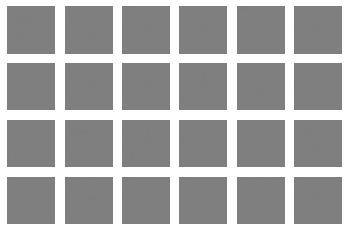


epochs 2
steps128

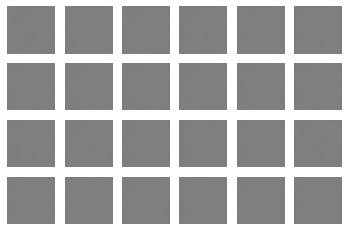


epochs 3
steps128

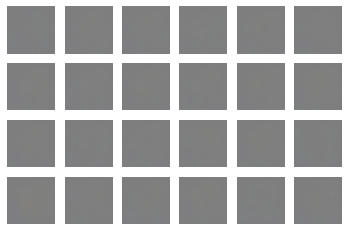


epochs 4
steps128

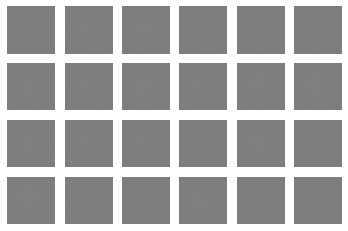


epochs 5
steps128

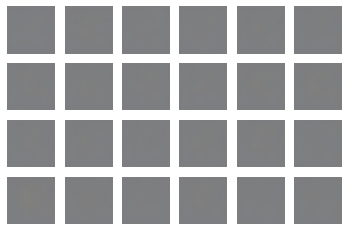


epochs 6
steps128

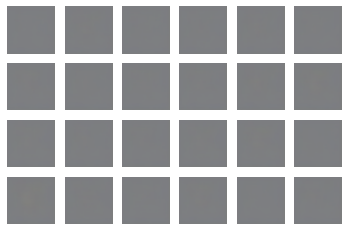


epochs 7
steps128

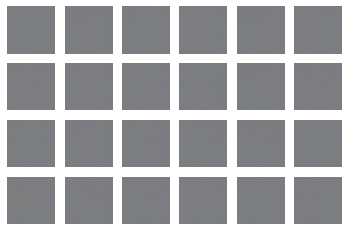


epochs 8
steps128

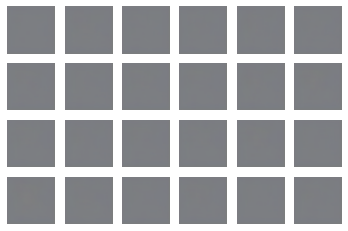


epochs 9
steps128

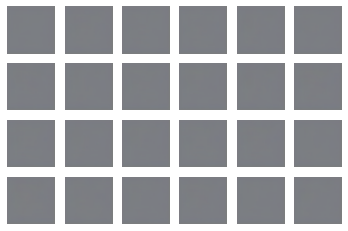


epochs 10
steps128

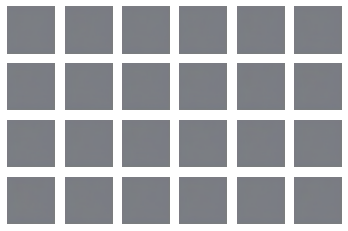


epochs 11
steps128

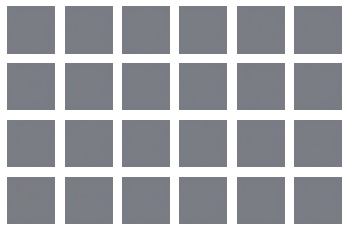


epochs 12
steps128

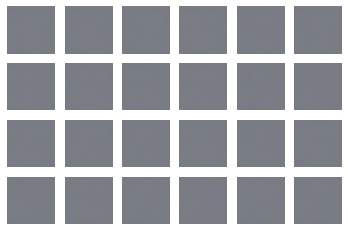


epochs 13
steps128

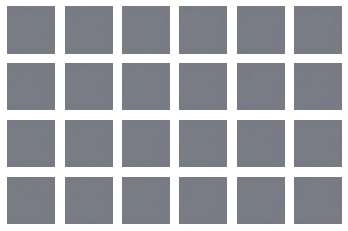


epochs 14
steps128

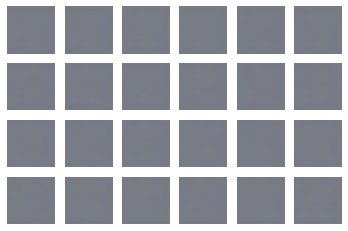


epochs 15
steps128

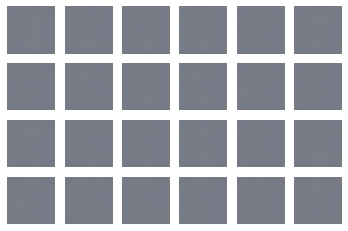


epochs 16
steps128

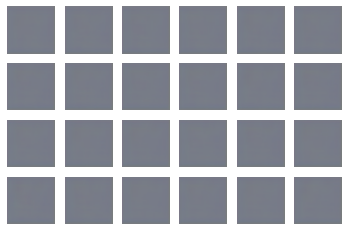


epochs 17
steps128

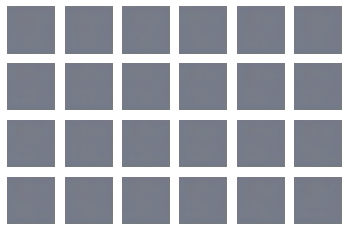


epochs 18
steps128

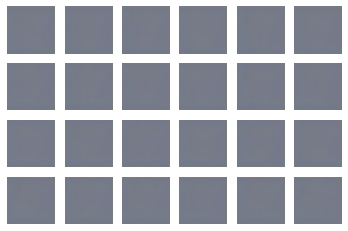


epochs 19
steps128

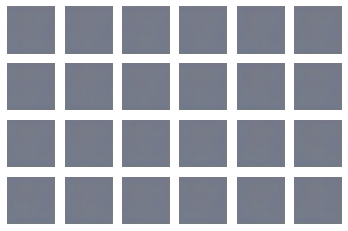


epochs 20
steps128

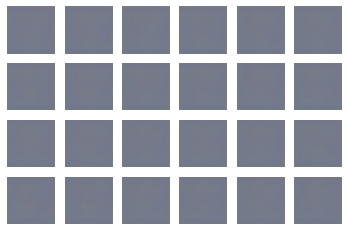


epochs 21
steps128

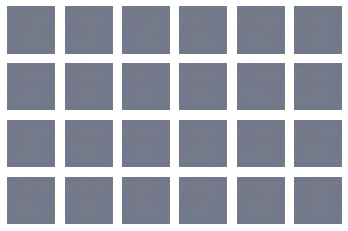


epochs 22
steps128

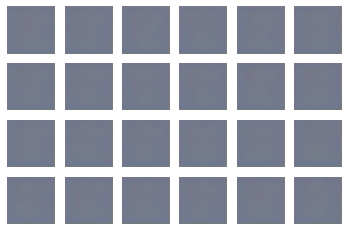


epochs 23
steps128

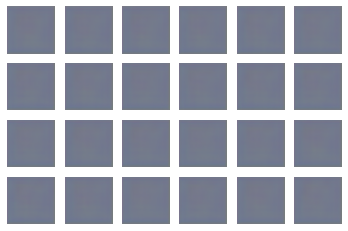


epochs 24
steps128

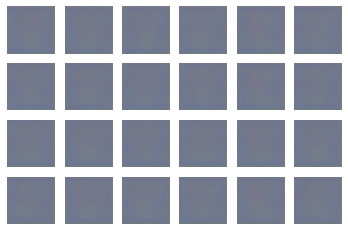


epochs 25
steps128

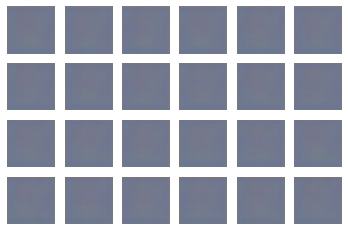


epochs 26
steps128

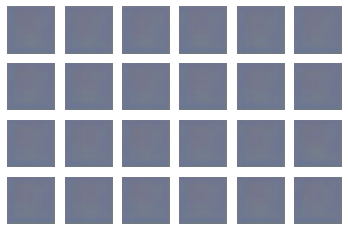


epochs 27
steps128

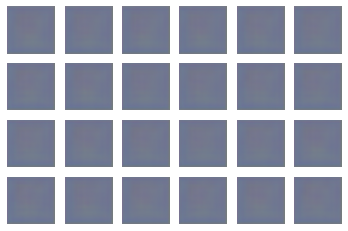


epochs 28
steps128

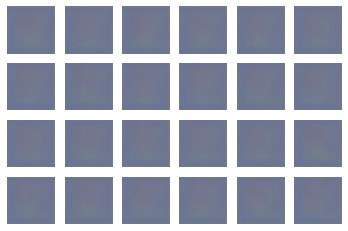


epochs 29
steps128

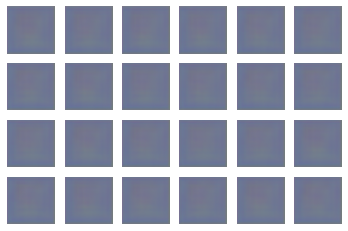


epochs 30
steps128

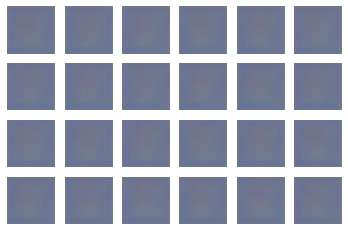


epochs 31
steps128

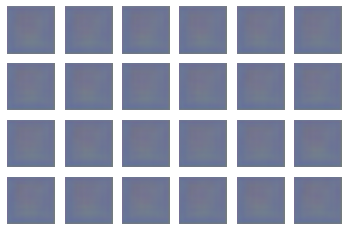


epochs 32
steps128

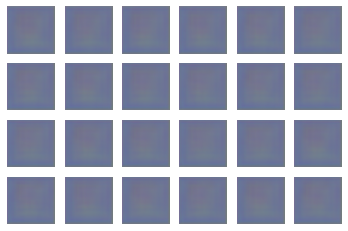


epochs 33
steps128

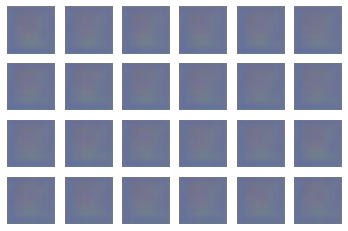


epochs 34
steps128

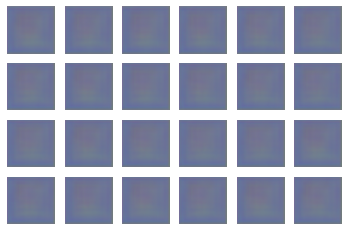


epochs 35
steps128

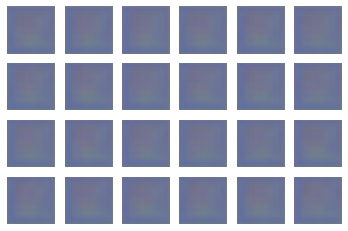


epochs 36
steps128

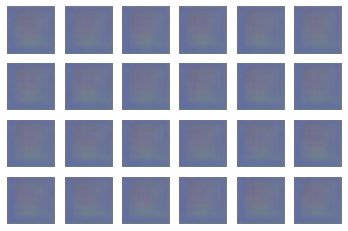


epochs 37
steps128

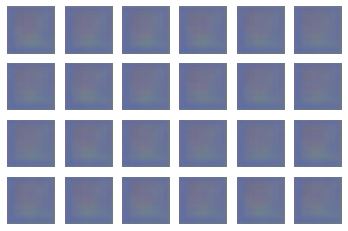


epochs 38
steps128

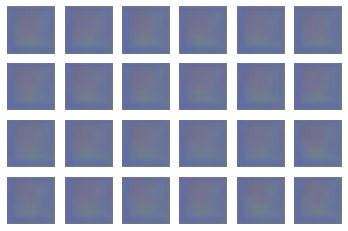


epochs 39
steps128

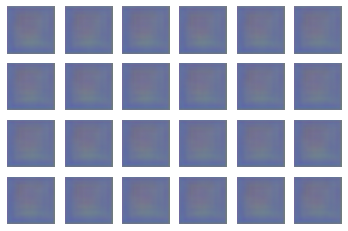


epochs 40
steps128

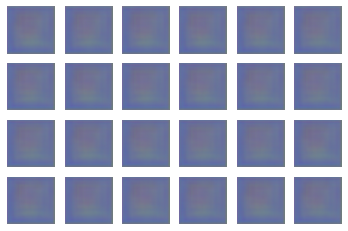


epochs 41
steps128

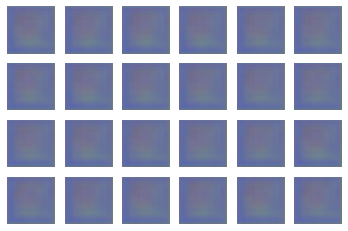


epochs 42
steps128

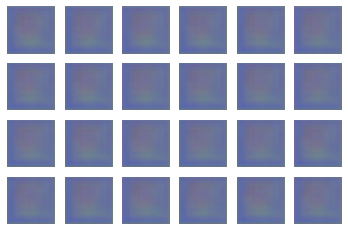


epochs 43
steps128

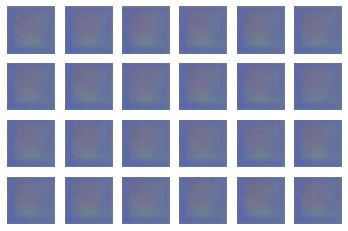


epochs 44
steps128

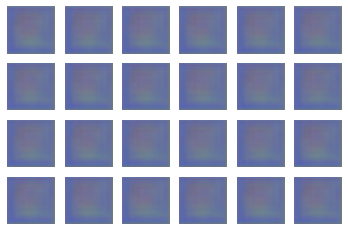


epochs 45
steps128

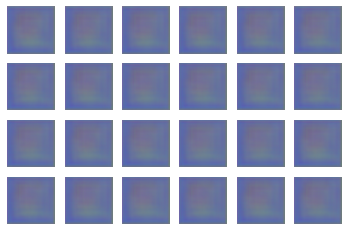


epochs 46
steps128

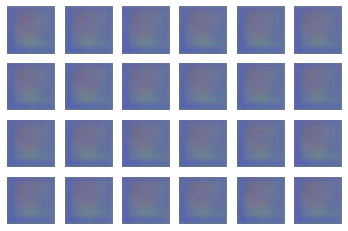


epochs 47
steps128

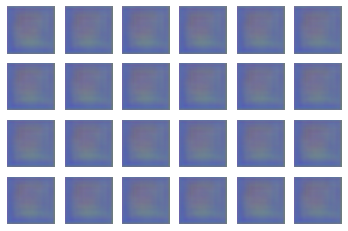


epochs 48
steps128

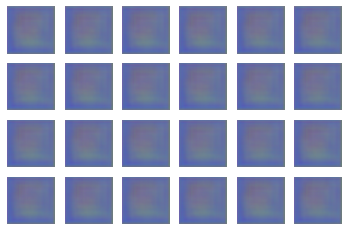


epochs 49
steps128

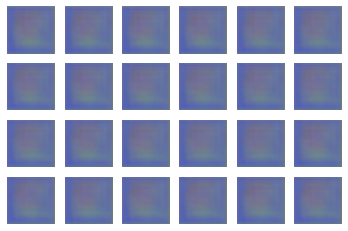


epochs 50
steps128

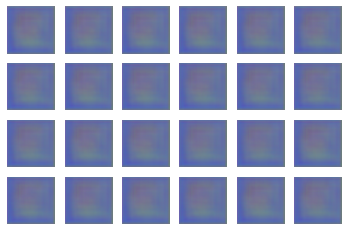


epochs 51
steps128

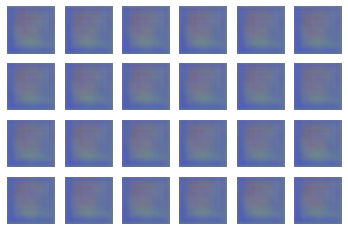


epochs 52
steps128

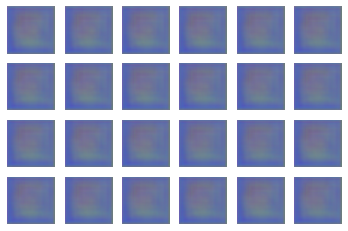


epochs 53
steps128

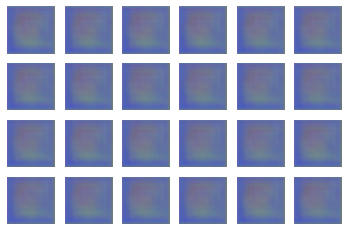


epochs 54
steps128

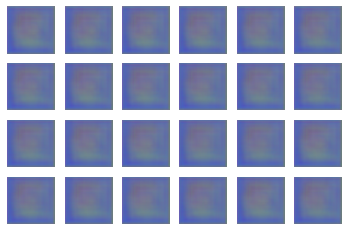


epochs 55
steps128

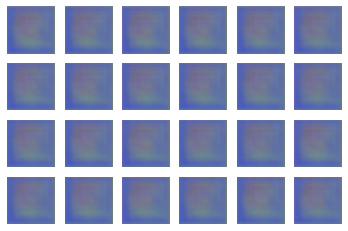


epochs 56
steps128

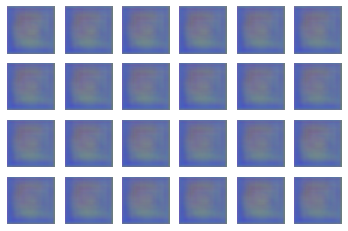


epochs 57
steps128

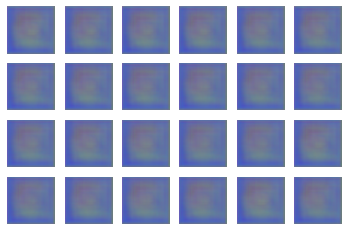


epochs 58
steps12

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import binary_crossentropy, MSE
import glob
import time
import random
import sys

class WGAN():
  def __init__(self, 
               img_size=128, 
               code_num = 2048,
               batch_size = 16, 
               train_epochs = 100, 
               train_steps = 8, 
               checkpoint_epochs = 25, 
               image_epochs = 1, 
               start_epoch = 1,
               optimizer = Adam(learning_rate = 1e-4),
               n_critics = 8
               ):
    
    self.batch_size = batch_size
    self.train_epochs =  train_epochs
    self.train_steps = train_steps
    self.checkpoint_epochs = checkpoint_epochs
    self.image_epochs = image_epochs
    self.start_epoch = start_epoch
    self.code_num = code_num
    self.img_size = img_size
    self.n_critics = n_critics
    
    self.gen_optimizer = optimizer
    self.disc_optimizer = optimizer

    g = Generator()
    self.gen = g.model()
    
    d = Discriminator()
    self.disc = d.model()

    checkpoint_dir = "drive/My Drive/WGAN/checkpoint"
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(gen_optimizer = self.gen_optimizer,
                                     disc_optimizer = self.disc_optimizer,
                                     gen = self.gen,
                                     disc = self.disc,
                                     )

    self.manager = tf.train.CheckpointManager(checkpoint, directory=checkpoint_dir, max_to_keep=2)

    train_image_path = 'drive/My Drive/samples/image'
    
    self.train_filenames = glob.glob(train_image_path + '/*.jpg') 

    checkpoint.restore(self.manager.latest_checkpoint)

    self.g_history = []
    self.d_history = []
    # self.endec_history = []  

  def preprocess_image(self, image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [self.img_size, self.img_size] )
    image = image/255  # normalize to [0,1] range
    return tf.cast(image, tf.float32)

  def load_and_preprocess_image(self, path):
    image = tf.io.read_file(path)
    return self.preprocess_image(image)

  def dataset(self, paths, batch_size):
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    path_ds = tf.data.Dataset.from_tensor_slices(paths)
    img_ds = path_ds.map(self.load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
    img_ds = img_ds.batch(batch_size)
    return img_ds

  def image_preparation(self, filenames, batch_size, steps):
    img_batch = []
    while 1:
      random.shuffle(filenames)
      for path in filenames:
        img_batch.append(path)
        if len(img_batch) == steps*batch_size:
          imgs = self.dataset(img_batch, batch_size)
          img_batch = []
          yield imgs

  def discriminator_loss(self, original_outputs, generated_outputs):
    real_loss = binary_crossentropy(tf.ones_like(original_outputs), original_outputs)
    generated_loss = binary_crossentropy(tf.zeros_like(generated_outputs), generated_outputs)
    loss_d = tf.math.reduce_mean(real_loss + generated_loss)
    return loss_d

  def generator_loss(self, generated_outputs):
    loss_g = tf.math.reduce_mean(binary_crossentropy(tf.ones_like(generated_outputs), generated_outputs))
    return loss_g

  def mse_loss(self, true, pred):
    loss =  tf.math.reduce_mean(MSE(true, pred))
    return loss

  def wasserstein_loss(self, ori_outputs, gen_outputs):
    d_loss = -tf.reduce_mean(ori_outputs) + tf.reduce_mean(gen_outputs)
    g_loss = -tf.reduce_mean(gen_outputs)
    return d_loss, g_loss
  
  def gan_train(self, imgs, n):
    noise =tf.random.uniform([self.batch_size, self.code_num], minval=0, maxval=1, dtype=tf.dtypes.float32)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      gen_imgs = self.gen(noise, training=True)

      ori_outputs = self.disc(imgs, training=True)
      gen_outputs = self.disc(gen_imgs, training=True)

      # ori_outputs, ori_styles = self.disc(imgs, training=True)
      # gen_outputs, gen_styles = self.disc(gen_imgs, training=True)
      
      # gen_loss = self.generator_loss(gen_outputs)      
      # disc_loss = self.discriminator_loss(ori_outputs, gen_outputs)

      # re_gen_imgs = self.gen(ori_styles, training=True)

      # endec_loss = self.mse_loss(imgs, re_gen_imgs)
      # self.endec_history.append(endec_loss)
      
      disc_loss, gen_loss = self.wasserstein_loss(ori_outputs, gen_outputs)
      self.g_history.append(gen_loss)
      self.d_history.append(disc_loss)

      # endec_rate = 10*(0.98**n)
      # g_loss = gen_loss + endec_loss * endec_rate
      # d_loss = disc_loss + endec_loss * endec_rate

      g_loss = gen_loss
      d_loss = disc_loss


    gradients_of_gen = gen_tape.gradient(g_loss, self.gen.trainable_variables)
    self.gen_optimizer.apply_gradients(zip(gradients_of_gen, self.gen.trainable_variables))

    gradients_of_disc = disc_tape.gradient(d_loss, self.disc.trainable_variables)    
    self.disc_optimizer.apply_gradients(zip(gradients_of_disc, self.disc.trainable_variables))

  def g_train(self, imgs):
    noise =tf.random.uniform([self.batch_size, self.code_num], minval=0, maxval=1, dtype=tf.dtypes.float32)

    with tf.GradientTape() as gen_tape:
      gen_imgs = self.gen(noise, training=True)

      ori_outputs = self.disc(imgs, training=False)
      gen_outputs = self.disc(gen_imgs, training=False)

      _, g_loss = self.wasserstein_loss(ori_outputs, gen_outputs)
      self.g_temp.append(g_loss)

    gradients_of_gen = gen_tape.gradient(g_loss, self.gen.trainable_variables)
    self.gen_optimizer.apply_gradients(zip(gradients_of_gen, self.gen.trainable_variables))

  def d_train(self, imgs):
    noise =tf.random.uniform([self.batch_size, self.code_num], minval=0, maxval=1, dtype=tf.dtypes.float32)

    with tf.GradientTape() as disc_tape:
      gen_imgs = self.gen(noise, training=False)

      ori_outputs = self.disc(imgs, training=True)
      gen_outputs = self.disc(gen_imgs, training=True)
      
      d_loss, _ = self.wasserstein_loss(ori_outputs, gen_outputs)
      self.d_temp.append(d_loss)

    gradients_of_disc = disc_tape.gradient(d_loss, self.disc.trainable_variables)    
    self.disc_optimizer.apply_gradients(zip(gradients_of_disc, self.disc.trainable_variables))

  def visualise_batch(self, s_1, epoch):
    gen_img = self.gen(s_1)  
    gen_img = (np.array(gen_img*255, np.uint8))
    fig, axes = plt.subplots(4, 6)
    for idx, img in enumerate(gen_img):
      p, q = idx//6, idx%6
      axes[p, q].imshow(img)
      axes[p, q].axis('off')
    
    save_name = 'drive/My Drive/WGAN/generated_image/'+'image_at_epoch_{:04d}.png'
    plt.savefig(save_name.format(epoch), dpi=200)
    plt.pause(0.1)
    plt.close('all')

  def loss_vis(self):
    plt.plot(self.g_history, 'b', self.d_history, 'r')
    plt.title('blue: g  red: d')
    plt.savefig('drive/My Drive/WGAN/loss/gan_loss.png')
    plt.close('all')
    # plt.plot(self.endec_history)
    # plt.savefig('drive/My Drive/WGAN/loss/endec_loss.png')
    # plt.close('all')

  def update_loss_history(self):
    self.d_history.append(sum(self.d_temp)/len(self.d_temp))
    self.g_history.append(sum(self.g_temp)/len(self.g_temp))
    self.d_temp = []
    self.g_temp = []

  def __call__(self):
    sample_noise =tf.random.uniform([24, self.code_num], minval=0, maxval=1, dtype=tf.dtypes.float32)
    image_loader = self.image_preparation(self.train_filenames, self.batch_size, self.train_steps)
    self.d_temp = []
    self.g_temp = []
    [w.assign(tf.clip_by_value(w, -0.01, 0.01)) for w in self.disc.variables]

    for epoch in range(self.start_epoch, self.train_epochs+1):
      print ('\nepochs {}'.format(epoch))
      imgs_ds = next(image_loader)

      for steps, imgs in enumerate(imgs_ds):
        print("\r" + 'steps{}'.format(steps+1), end="")
        sys.stdout.flush()

        self.d_train(imgs)
        [w.assign(tf.clip_by_value(w, -0.01, 0.01)) for w in self.disc.variables]

        if steps % self.n_critics == 0:
          self.g_train(imgs)
        
      self.update_loss_history()
                               
      if epoch % self.image_epochs == 0:
        self.visualise_batch(sample_noise, epoch)
        self.loss_vis()

      if epoch % self.checkpoint_epochs == 0:
        print ('\nSaving checkpoint at epoch{}\n\n'.format(epoch))
        self.manager.save()
      
if __name__ == '__main__':
  a = WGAN(img_size = 128,
           code_num = 8,
           batch_size = 16,
           train_epochs = 10000, 
           train_steps = 128, 
           checkpoint_epochs = 100, 
           image_epochs = 1, 
           start_epoch = 1,
           optimizer = RMSprop(lr=5E-5),
           n_critics = 128
           )
  a()